# Principal component analysis for multi-spectral data

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)


## Background

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction.
It can be used to explore patterns in high-dimensional data and assist unsupervised learning.

Principal components are a series of linear combinations of the original variables, among which the first principal component accounts for the greatest variance within a dataset.
Each subsequent principal component accounts for the next greatest possible variance and is uncorrelated with the previously defined components.

This technique is useful for understanding Sentinel-2 data as images are captured in 12 spectral bands but only 3 variables can be visualized in a RGB composite.
PCA can also be applied to timeseries data to investigate temporal evolution patterns for different land cover types.

## Description

This notebook demonstrates a principal component analysis for Sentinel-2 multi-spectal data. 
Following steps are covered:

1. Loading Sentinel-2 multi-spectral data.
2. Applying PCA to transform and visualize data.
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

from sklearn.decomposition import PCA
import datacube

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb
from deafrica_tools.classification import sklearn_flatten, sklearn_unflatten

### Connect to the datacube

Connect to the datacube so we can access DEAfrica data.

In [2]:
dc = datacube.Datacube(app='pca')

### Analysis parameters

This section defines the analysis parameters, including 

* center lat/lon and analysis window size for the area of interest
* time period to be investigated
* projection and resolution for loading data
* acceptable range of cloud cover percentage for input Sentinel-2 granule (`min_gooddata`)
* spectral bands to be explored

The default location is Betsiboka Estuary, Madagascar.

To limit overall memory usage, if a larger analysis window or higher resolution is desired, the time period should be reduced accordingly.

In [3]:
# Create a query object
lat, lon = -15.92, 46.35
buffer = 0.1 

query = {
    'time': ('2020-01', '2020-03'),
    'x': (lon - buffer, lon + buffer),
    'y': (lat + buffer, lat - buffer),
    'output_crs': 'epsg:6933',
    'resolution':(-20,20),
}

# use all non-overlapping 10m and 20m bands
bands = ['blue', 'green', 'red', 'red_edge_1', 'red_edge_2',
         'red_edge_3', 'nir_narrow', 'swir_1', 'swir_2']

## Loading Sentinel-2 multi-spectral data

Only high probablity cloud is excluded in this example, but this can be modified for a different area.


In [4]:
ds = load_ard(dc=dc,
              products=['s2_l2a'],
              measurements=bands,
              min_gooddata=0.98,
              group_by='solar_day',
              **query)


Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step


CPLReleaseMutex: Error = 1 (Operation not permitted)


Filtering to 4 out of 18 time steps with at least 98.0% good quality pixels
Applying pixel quality/cloud mask
Loading 4 time steps


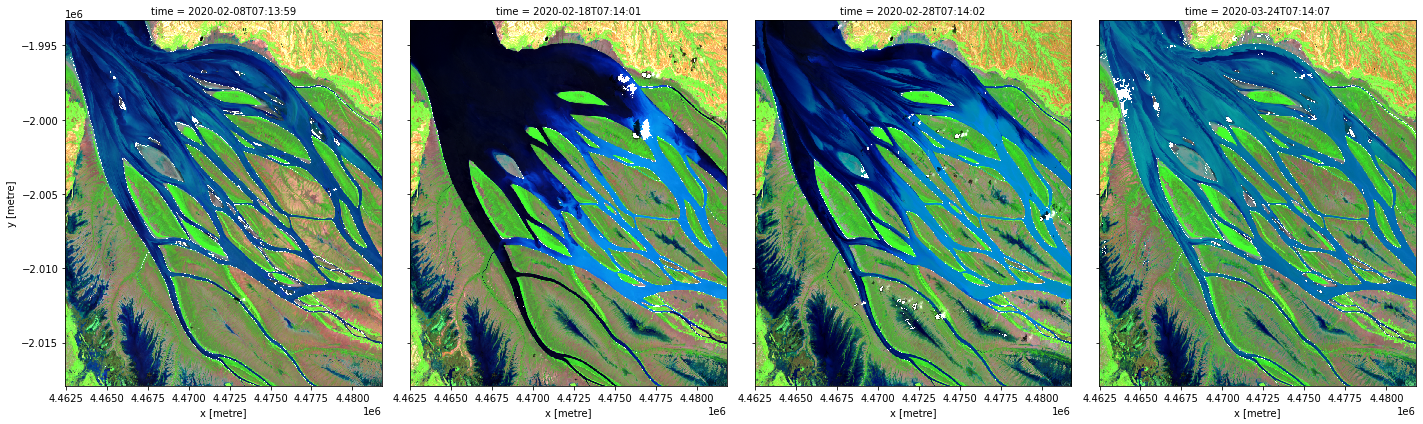

In [5]:
# visualize data using selected input spectral bands
rgb(ds, bands=['swir_1','nir_narrow','red_edge_1'], index=list(range(len(ds.time))), col_wrap=4)

## Applying PCA to transform and visualize data

To perform a PCA, data is first transformed into a numpy array that can be used by sklearn.

In [13]:
X = sklearn_flatten(ds)
X

array([[ 406.,  838., 1090., ...,  250.,  114.,   98.],
       [ 378.,  749.,  466., ...,   56.,   23.,   13.],
       [ 348.,  880., 1854., ...,  734.,   28.,   10.],
       ...,
       [ 195.,  476.,  566., ..., 1087.,  298.,  126.],
       [ 218.,  484.,  484., ...,  884.,  295.,  154.],
       [ 352.,  921.,  563., ..., 2513.,  946.,  454.]], dtype=float32)

In [15]:
import xarray as xr
import numpy as np

In [19]:
# Figure out how sklearn works
input_xr = ds
# the output of a sklearn model prediction should just be a numpy array
# with size matching x*y*time for the input DataArray/Dataset.

# cast input Datasets to DataArray
if isinstance(input_xr, xr.Dataset):
    input_xr = input_xr.to_array()

# generate the same mask we used to create the input to the sklearn model
if "time" in input_xr.dims:
    stacked = input_xr.stack(z=["x", "y", "time"])
else:
    stacked = input_xr.stack(z=["x", "y"])
    
stacked

<xarray.DataArray (variable: 9, z: 4748856)>
array([[ 406.,  378.,  348., ...,  195.,  218.,  352.],
       [ 838.,  749.,  880., ...,  476.,  484.,  921.],
       [1090.,  466., 1854., ...,  566.,  484.,  563.],
       ...,
       [ 250.,   56.,  734., ..., 1087.,  884., 2513.],
       [ 114.,   23.,   28., ...,  298.,  295.,  946.],
       [  98.,   13.,   10., ...,  126.,  154.,  454.]], dtype=float32)
Coordinates:
    spatial_ref  int32 6933
  * variable     (variable) <U10 'blue' 'green' 'red' ... 'swir_1' 'swir_2'
  * z            (z) MultiIndex
  - x            (z) float64 4.462e+06 4.462e+06 ... 4.482e+06 4.482e+06
  - y            (z) float64 -1.993e+06 -1.993e+06 ... -2.018e+06 -2.018e+06
  - time         (z) datetime64[ns] 2020-02-08T07:13:59 ... 2020-03-24T07:14:07
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

In [42]:
# Get the shape for stacked.
print(stacked.shape)

# Get the shape of the dataset.
print(ds.to_array().shape)

(9, 4748856)
(9, 4, 1229, 966)


In [43]:
# Get the first column of stacked.
print(stacked.values[: ,0])
# This column corresponds to the first value for each of the variales in the dataset. 
print(ds.to_array().values[: ,0,0, 0])

[ 406.  838. 1090. 1054.  378.  398.  250.  114.   98.]
[ 406.  838. 1090. 1054.  378.  398.  250.  114.   98.]


In [44]:
# Get the last column of stacked.
print(stacked.values[: ,4748855])
# This column corresponds to the last value for each of the variables in the dataset. 
print(ds.to_array().values[ : ,3,1228, 965])

[ 352.  921.  563. 1587. 2433. 2596. 2513.  946.  454.]
[ 352.  921.  563. 1587. 2433. 2596. 2513.  946.  454.]


In [98]:
# Get the first row for stacked.
print(stacked.values[0, :])
# In some form it is equal to this but needs configuring.
print(ds.blue.values.flatten(order = 'F'))

[406. 378. 348. ... 195. 218. 352.]
[406. 378. 348. ... 195. 218. 352.]


In [127]:
# The hypothesis is that each row of stacked is one variable of the dataset.
# In this case the first row of stacked matches the ds.blue variable.
# We need to find until which point in slicing do they cease to match.
i = 376
np.unique(stacked.values[0, :][0:i] == ds.blue.values.flatten(order = 'F')[0:i])

array([ True])

In [128]:
i = 377
np.unique(stacked.values[0, :][0:i] == ds.blue.values.flatten(order = 'F')[0:i])

array([False,  True])

In [136]:
# up to 366 do they match 
i = 377
print("Stacked:\n", stacked.values[0, :][0:i])
print("Ds:\n", ds.blue.values.flatten(order = 'F')[0:i])

Stacked:
 [406. 378. 348. 386. 414. 365. 359. 412. 410. 367. 350. 382. 336. 361.
 359. 362. 374. 358. 354. 377. 394. 361. 356. 399. 448. 365. 359. 393.
 459. 361. 339. 377. 459. 374. 368. 402. 452. 336. 332. 375. 459. 338.
 359. 407. 478. 365. 348. 407. 458. 361. 371. 418. 482. 358. 367. 429.
 455. 384. 360. 440. 470. 374. 355. 408. 470. 370. 360. 419. 464. 341.
 352. 429. 479. 374. 360. 380. 443. 358. 352. 417. 458. 393. 360. 405.
 485. 394. 347. 395. 454. 377. 361. 401. 492. 381. 336. 389. 454. 390.
 336. 417. 480. 377. 347. 400. 454. 378. 361. 353. 475. 395. 360. 371.
 431. 385. 352. 371. 462. 369. 358. 390. 438. 369. 346. 390. 462. 389.
 352. 373. 455. 385. 372. 358. 451. 383. 379. 358. 462. 405. 369. 341.
 462. 395. 367. 336. 462. 395. 360. 324. 450. 360. 359. 340. 422. 395.
 366. 342. 452. 389. 375. 315. 433. 383. 358. 321. 446. 379. 375. 277.
 445. 379. 370. 307. 472. 389. 361. 307. 472. 373. 347. 322. 445. 380.
 350. 318. 460. 383. 339. 358. 450. 382. 346. 309. 466. 389. 350. 2

In [91]:
np.unique(stacked.values[0, :][0:i] == ds.blue.values.flatten(order = 'F')[0:i])


array([ True])

In [95]:
i = 0 
while i<10:
    eval = np.unique(stacked.values[0, :][0:i] == ds.blue.values.flatten(order = 'F')[0:i])
    if False in eval:
        break
    else:
        i=+1
    

KeyboardInterrupt: 

In [88]:
while True:
    for i in range(4748856):
        eval = np.unique(stacked.values[0, :][0:i] == ds.blue.values.flatten(order = 'F')[0:i])
        if False in eval: 
            break
print(i)

KeyboardInterrupt: 

In [69]:
ds.blue.values.flatten(order = 'A')

array([406., 447., 431., ..., 481., 379., 352.], dtype=float32)

In [70]:
ds.blue.values.flatten(order = 'K')

array([406., 447., 431., ..., 481., 379., 352.], dtype=float32)

In [71]:
ds.blue.values.flatten(order = 'C')

array([406., 447., 431., ..., 481., 379., 352.], dtype=float32)

In [72]:
ds.blue.values.reshape(-1,)

array([406., 447., 431., ..., 481., 379., 352.], dtype=float32)

array([406., 447., 431., ..., 481., 379., 352.], dtype=float32)

In [53]:
## Figure out how raster_stack works
ds.blue.values[:, 0, 0 ]

array([406., 378., 348., 386.], dtype=float32)

In [50]:
ds.blue.values.shape

(4, 1229, 966)

In [23]:
# Get the bands for the dataset.
bands_list = list(ds.data_vars)
for i, band in enumerate(bands_list):
    print(i, band)

0 blue
1 green
2 red
3 red_edge_1
4 red_edge_2
5 red_edge_3
6 nir_narrow
7 swir_1
8 swir_2


A PCA model is generated with 3 principal components and fitted on the data.

In [7]:
pca = PCA(n_components=3)
pca.fit(X)

PCA(n_components=3)

We can investigate how much variance is accounted for in each principal component.
In the default example, the first principal component accounts for a much high variance than the next two.

This step can help determine whether more principal components are needed.

In [8]:
print("Relative variance in principal components:", pca.explained_variance_ratio_)

Relative variance in principal components: [0.63061505 0.21630614 0.14659804]


The input data can now be transformed into this new reference space and rearranged into a xarray dataset compatible with input data.

In [9]:
predict = pca.transform(X)

In [10]:
out = sklearn_unflatten(predict, ds)

In [11]:
out = out.to_dataset(dim=out.dims[0]).transpose('time','y','x')

### Visualise PCA results

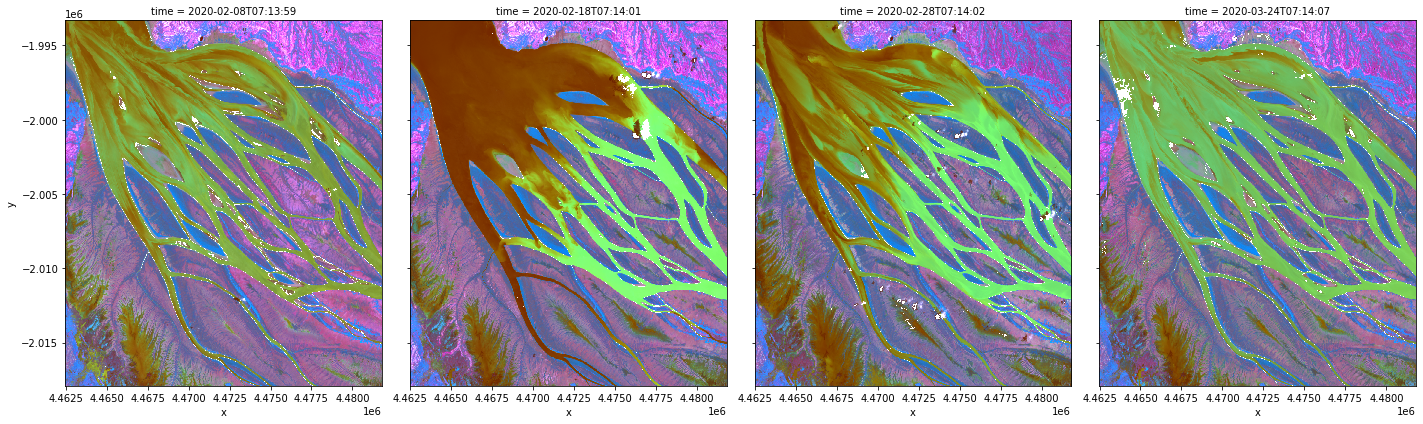

In [12]:
rgb(out, bands=[2,1,0], index=list(range(len(out.time))), col_wrap=4)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [13]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [14]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-12-06'